# Water Quality Network
For our network project, Cassie and I are thinking of creating a bipartite network where the nodes are pollutants and the links are water facilities whose measurements of those pollutants are above the threshold. By doing this linking, we hope to see what the biggest pollutants are, how pollutants might connect to one another, and if there are any pollutants that we should be worried about.

## Data Sources
We got our data from USGS (U.S. Geological Survey). I'll need to get the exact link later.

## Looking at the data
Since I'm not too familiar with the data, let's load it in and take a look. There's some preliminary things that I do know, which will be come prevelant when you look at the code. For instance, you can break up the code into chunks by splitting on instances of "#\n". The # comes from the file header and most "sections" within the header are separated by # followed by a new line. The last item of the split is the actual data.

Let's start by loading in everything!

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data(file_name):
    data = []
    with open(file_name, 'r') as file:
        data = file.read().split("#\n")

    if not data:
        print("File {} was unable to be read.".format(file_name))
    return data

In [3]:
file_name = "LA_Water_Quality_Data.txt"
data = load_data(file_name)
print("Number of sections:", len(data))
print("2nd section:", data[2], sep = "\n")
print("Number of characters in actual data:", len(data[15]))

Number of sections: 16
2nd section:
# U.S. Geological Survey
# 
# This file contains selected water-quality data for stations in the National Water Information 
# System water-quality database.  Explanation of codes found in this file are followed by
# the retrieved data.

Number of characters in actual data: 9736982


Great! We have 15 chunks of text when doing that split (which feels a bit better than doing it line-by-line). Here's a breakdown of what's inside:
    #  0:                               #  8: coll_ent_cd  
    #  1: File created...               #  9: medium_cd  
    #  2: U.S. Geological Survey        # 10: tu_id  
    #  3: The data you have...          # 11: body_part_id  
    #  4: To view additional...         # 12: remark_cd  
    #  5: Param_id      - parameter     # 13: Data for the following sites...  
    #  6: sample_start_time_datum_cd    # 14: WARNING: some preadsheet...  
    #  7: tm_datum_rlbty_cd             # 15: Data!  

I've already glanced at the file in Excel and figured out how to parse all of the parameters and their descriptions, which will probably be useful later on. 

In [4]:
# inputs the part of the header that contains the parameter label followed by its meaning
# outputs a dictionary where the key is the label (lower case) and the value is the description
def get_parameter_def(param_header):
    params_dict = {}
    params_type = {}
    params = param_header.split("\n")
    params_pattern = re.compile("# +(\w+) +- +(.+)")

    for param in params:
        a = params_pattern.search(param)

        if a: 
            #print(first_t, a.group(1), a.group(2))
            params_dict[a.group(1).lower()] = a.group(2)
            #print(a.group(1) + ":", a.group(2).split(',')[-1])

    return params_dict

In [5]:
params_dict = get_parameter_def(data[5])
print("Total number of parameters measured:", len(params_dict))

Total number of parameters measured: 1046


In [6]:
params_dict

{'agency_cd': 'Agency Code',
 'site_no': 'Station number',
 'sample_dt': 'Begin date',
 'sample_tm': 'Begin time',
 'sample_end_dt': 'End date',
 'sample_end_tm': 'End time',
 'sample_start_time_datum_cd': 'Time datum',
 'tm_datum_rlbty_cd': 'Time datum reliability code',
 'coll_ent_cd': 'Agency Collecting Sample Code',
 'medium_cd': 'Medium code',
 'tu_id': 'Taxonomic unit code',
 'body_part_id': 'Body part code',
 'p00003': 'Sampling depth, feet',
 'p00004': 'Stream width, feet',
 'p00005': 'Location in cross section, fraction of total depth, percent',
 'p00008': 'Sample accounting number',
 'p00009': 'Location in cross section, distance from left bank looking downstream, feet',
 'p00010': 'Temperature, water, degrees Celsius',
 'p00011': 'Temperature, water, degrees Fahrenheit',
 'p00020': 'Temperature, air, degrees Celsius',
 'p00021': 'Temperature, air, degrees Fahrenheit',
 'p00025': 'Barometric pressure, millimeters of mercury',
 'p00028': 'Agency analyzing sample, code',
 'p000

In [16]:
filtered_params = {}
unfiletered_params = {}
collapsed_params_dict = {}
for param in params_dict.items():
    components = param[1].split(", ")
    component = components[0]
    if len(component) == 1:
        component = component + "," + components[1]
    if re.search(pattern="  +", string=component):
        component = component.split()[0]
        
    component = component.lower()
    if component not in collapsed_params_dict:
        collapsed_params_dict[component] = 0
    collapsed_params_dict[component] += 1
    
collapsed_params_dict

file = open("parameter_list.txt", "w")
for param in collapsed_params_dict:
    file.write(param + "\n")
file.close()

IndexError: list index out of range

In [8]:
a = pd.read_csv(pd.compat.StringIO(data[15]), sep='\t', low_memory=False, header=0, skiprows=[1])
# I find this a bit concerning...: https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options
# I'd want to specify type, but it seems like there's a lot of strings within supposedly numerical columns...
print(a.shape)

(7763, 1046)


In [9]:
display(a)

,agency_cd,site_no,sample_dt,sample_tm,sample_end_dt,sample_end_tm,sample_start_time_datum_cd,tm_datum_rlbty_cd,coll_ent_cd,medium_cd,...,p99856,p99871,p99931,p99947,p99958,p99959,p99963,p99972,p99994,p99995
0,USGS,332031118504001,2000-10-24,14:30,NaN,NaN,PDT,T,USGS-WRD,WG,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS,333420118060501,2000-11-09,09:30,NaN,NaN,PST,T,USGS-WRD,WG,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USGS,333420118060501,2006-08-30,08:20,NaN,NaN,PDT,K,USGS-WRD,WG,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,973.0,90.7,99.8
3,USGS,333420118060501,2006-08-30,08:30,NaN,NaN,PST,K,USGS-WRD,WG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USGS,333420118060501,2006-08-30,08:40,NaN,NaN,PDT,K,USGS-WRD,WG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,USGS,334607118053801,1995-08-30,15:25,NaN,NaN,PDT,T,USGS-WRD,WG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,USGS,334607118053901,1995-08-30,14:30,NaN,NaN,PDT,T,USGS-WRD,WG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,USGS,334626118043601,1956-04-18,NaN,NaN,NaN,PST,T,NaN,WG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,USGS,334626118043601,1960-07-11,NaN,NaN,NaN,PST,T,NaN,WG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,USGS,334637118172701,1999-03-19,09:30,NaN,NaN,PST,T,USGS-WRD,WG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Let's see how much data we have for each parameter...
params_counts_dict = {}
for param in a:
    count = a.shape[0] - sum(a[param].isna())
    if count > 0:
        params_counts_dict[params_dict[param]] = count
    
    #print(params_dict[param] + ":", count)
params_counts = list(params_counts_dict.values())

(array([961.,  25.,  18.,   5.,  13.,   2.,   2.,   2.,   1.,   6.]),
 array([1.0000e+00, 7.7720e+02, 1.5534e+03, 2.3296e+03, 3.1058e+03,
        3.8820e+03, 4.6582e+03, 5.4344e+03, 6.2106e+03, 6.9868e+03,
        7.7630e+03]),
 <a list of 10 Patch objects>)

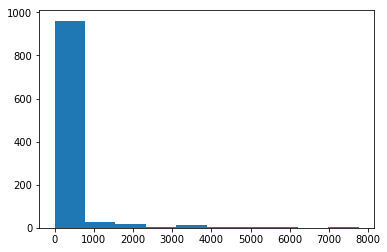

In [11]:
plt.hist(list(params_counts_dict.values()))

In [12]:
counts_of_counts = {}
for count in params_counts_dict.values():
    if count not in counts_of_counts:
        counts_of_counts[count] = 0
    counts_of_counts[count] += 1

param_counts = list(params_counts_dict.values())
count_counts = list(counts_of_counts.values())
bin_edges = np.logspace(np.log10(min(param_counts)), 
                        np.log10(max(param_counts)),
                        num = 10)
density, _ = np.histogram(param_counts, bins=bin_edges, density=True)

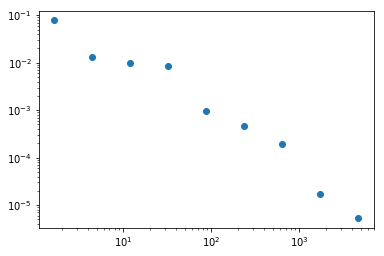

In [13]:
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')

In [14]:
log_be

array([0.        , 0.43222551, 0.86445102, 1.29667653, 1.72890204,
       2.16112755, 2.59335306, 3.02557857, 3.45780408, 3.89002959])

filter vs unfiltered
* unfiltered = grab the ground water as is - you have extra sediment somehow
* filtered = you filter out the ground water 
* do analysis with filtered and unfiltered, but DON'T MIX
* higher pollution for unfiltered properties

In [26]:
filtered_params = {}
unfiltered_params = {}
for param in params_dict.items():
    components = param[1].split(", ")
    if "filtered" in components or "unfiltered" in components:
        component = components[0]
        if components[2] == "filtered":
            if component not in filtered_params:
                filtered_params[component] = []
            filtered_params[component].append(param[0])
        elif components[2] == "unfiltered":
            if component not in unfiltered_params:
                unfiltered_params[component] = []
            unfiltered_params[component].append(param[0])

In [27]:
filtered_params

{'Color': ['p00080'],
 'Carbonate': ['p00452', 'p29807', 'p63788'],
 'Bicarbonate': ['p00453', 'p29804', 'p63786'],
 'Dissolved solids dried at 105 degrees Celsius': ['p00515'],
 'Loss on ignition of dissolved solids': ['p00520'],
 'Total nitrogen [nitrate + nitrite + ammonia + organic-N]': ['p00602',
  'p62854'],
 'Organic nitrogen': ['p00607'],
 'Ammonia (NH3 + NH4+)': ['p00608', 'p71846'],
 'Nitrite': ['p00613', 'p71856'],
 'Nitrate': ['p00618', 'p71851'],
 'Ammonia plus organic nitrogen': ['p00623'],
 'Nitrate plus nitrite': ['p00631'],
 'Orthophosphate': ['p00660', 'p00671'],
 'Phosphorus': ['p00666'],
 'Organic carbon': ['p00681'],
 'Sulfide': ['p00746', 'p99118'],
 'Noncarbonate hardness': ['p00904', 'p00905'],
 'Calcium': ['p00915'],
 'Magnesium': ['p00925'],
 'Sodium': ['p00930'],
 'Sodium plus potassium': ['p00933'],
 'Potassium': ['p00935'],
 'Chloride': ['p00940'],
 'Sulfate': ['p00945'],
 'Fluoride': ['p00950', 'p91002'],
 'Silica': ['p00955'],
 'Arsenic': ['p01000'],
 'Ba

In [35]:
unfiltered_file = open("Unfiltered_params.txt", "w")
filtered_file = open("Filtered_params.txt", "w")

for param in unfiltered_params.items():
    formatSTR = param[0] + "\t" + "\t".join(param[1]) + "\r\n"
    unfiltered_file.write(formatSTR.lower())
unfiltered_file.close()
for param in filtered_params.items():
    formatSTR = param[0] + "\t" + "\t".join(param[1]) + "\r\n"
    filtered_file.write(formatSTR.lower())
filtered_file.close()
    

In [33]:
unfiltered_params["Turbidity"]

['p00070', 'p00075', 'p00076', 'p61028', 'p63675', 'p63676', 'p63680']

In [37]:
for p in unfiltered_params["Turbidity"]:
    print(params_dict[p])

Turbidity, water, unfiltered, Jackson Turbidity Units
Turbidity, water, unfiltered, Hellige turbidimeter, milligrams per liter as silicon dioxide
Turbidity, water, unfiltered, nephelometric turbidity units
Turbidity, water, unfiltered, field, nephelometric turbidity units
Turbidity, water, unfiltered, broad band light source (400-680 nm), detection angle 90 +-30 degrees to incident light, nephelometric turbidity units (NTU)
Turbidity, water, unfiltered, broad band light source (400-680 nm), detectors at multiple angles including 90 +-30 degrees, ratiometric correction, NTRU
Turbidity, water, unfiltered, monochrome near infra-red LED light, 780-900 nm, detection angle 90 +-2.5 degrees, formazin nephelometric units (FNU)


In [ ]:
thresholds = pd.ExcelFile("Pollutant_Thresholds_human_health.xlsx")
thresholds_data = thresholds.

In [40]:
data[15].split("\n")[1]

'5s\t15s\t10d\t5d\t10d\t5d\t3s\t1s\t8s\t3s\t11s\t11s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t12s\t1